# WeatherPy
----
### Background / Issues
* Goal:  rigorous, data-driven, qualitative model of the relationship between weather conditions and latitude
* Basic approach:  sample key current weather conditions (temperature, humidity, wind speed, and cloud cover) around the world using  OpenWeatherMap API queries by city, then test hypotheses about the correlation between these conditions and latitude
* Issues:  "City weather" is different from weather in general.  Cities are on land, tend to be near large bodies of water, and tend not to be at high elevation, in polar regions, on rugged terrain, in deserts, etc.  As a result, the model will test hypotheses about the relationship between current weather conditions near population centers and latitude
* Please see the "README" deisgn doc for more detailed discussion and instructions for use.


### Analysis Summary
* A likely significant positive statistical correlation between distance from the equator and temperature was observed.  In other words, we can rigorously show that indeed the cities of the world are warmer near the equator.   
* A weak but likely statistically significant positive correlation between wind speed and distance from the equator was also observed, due more to an absence of strong winds observed in cities near the equator.  Humidity and cloud cover did not correlate signfiicant with either latitude or distance from the equator.
* Other expected correlations (such as the expected positive correlation between cloud cover and humidity) also were present in the data, but were substantially weaker than the correlations involving temperature and latitude.

In [3]:
# Dependencies and Setup -- standard tools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# We also need some t-statistics
from scipy.stats import t
# We will make use of some Unix dates
from datetime import datetime
# and time.sleep to control server load
import time
# To manage API calls, we will use the openweathermapy functions and the API key
import openweathermapy.core as owm
from config import api_key
# To handle HTTP errors generated with openweathermapy, we need urllib
import urllib
# To correctly calculate minimum distances on the surface of the Earth, we need the haversine function
from haversine import haversine
# Input File (CSV)
input_data_file = 'citipy/worldcities.csv'
# Output File (CSV)
output_data_file = 'output_data/cities.csv'
# Log File (TXT)
output_log = 'output_data/log.txt'

### Code Parameters 

In [4]:
# lat_radius sets the maximum distance a city can be from a search point (in deg latitude, 
# which means 1.0 = 111 km, 2.0 = 222 km, etc).  Smaller = less efficient building of city lists
# but larger = more biased sampling of cities on coastlines and edges of populated regions 
lat_radius = 1.0
# Querying will stop once the number of cities with valid weather data reaches data_size,
# but in order to avoid an infinite query loop and manage server load, queries will be 
# done in sets of batch_size, with max_batches being the overriding limiting factor.
# To make sure queries do not stop before reaching data_size, set max_batches > 1.6 * data_size / batch_size
batch_size = 20
data_size = 500
max_batches = 40
# In order to keep the program from running an infinite loop while searching for cities to query,
# wlr sets the ratio of attempts to the target number to be found.  Because oceans cover the majority
# of Earth's surface, for random sampling to work, wlr should be at least 3, preferably about 2x larger.
# If the city search comes up short of its target, the notebook will ask you to increase wlr or lat_radius.
wlr = 6        #Use an integer

### Prepare City Data
By importing directly from the csv, we lose the kd-tree structure from citipy, but we gain much improved sampling capability.

In [5]:
# Create a DataFrame from the citipy input file, sort by latitude (then longitude), and use the latitude as the index
city_df = pd.read_csv(input_data_file).sort_values(by=['Latitude','Longitude']).set_index('Latitude', drop=False)
# A latitude-based index will speed up the city search greatly
city_df.head()

,Country,City,Latitude,Longitude
Latitude,,,,
-54.800000,ar,ushuaia,-54.800000,-68.300000
-53.150000,cl,punta arenas,-53.150000,-70.916667
-51.622613,ar,rio gallegos,-51.622613,-69.218127
-46.600000,nz,bluff,-46.600000,168.333333
-46.400000,nz,invercargill,-46.400000,168.350000


## Generate Cities List

In [6]:
def getcities(batch=batch_size, radius = lat_radius, maxtries = wlr * batch_size, found = []):
    '''Returns a list of unique city names by random sampling of the surface of the Earth (assumes perfect sphere).
    The parameters are: 1) batch sets the target number of cities to return, defaults to notebook constant
                        2) radius sets the maximum distance from the target that a city can be (in equiv. deg lat)
                           which means 1.0 = 111.13 km, 2.0 = 222.26 km, etc., defaults to a notebook constant
                        3) maxtries sets the maximum number of attempts, defaults to a notebook constant
                        4) found sets a list of city names to exclude (useful if calling the function multiple times)
    This function depends on a latitude-sorted, latitude-indexed global DataFrame called city_df.  
    Larger values of radius will sample cities in a more biased way, but small values will require many tries.'''
# Variables for holding city names and search count.  For safety, function will stop at a fixed number of searches.
    cities = []   # Using a list ends up simpler than a set
    searches = 0
# Ignore capital letters, and merge into a set for checking.  
    found = [item.lower() for item in found]
# Loop through until we get the required number of successes or exhaust tries:
    while len(cities) <  batch and searches <  maxtries:
        city_name = ''
        max_dist = 111.13 * radius  #Converts latitude degrees to km, based on average radius of Earth
        # Choose a random point on Earth's surface, the arc cos part corrects for contraction of longitude near poles
        lat = 180.0 / 3.1416 *  np.arccos(2 * np.random.rand() -1) - 90
        lng = 360.0 * np.random.rand() - 180.0
        # The search is a two-part filter.  The first is a fast filter by lat to speed up the search.
        # We do not filter on lngs because the modular arithmetic and nonlinearity make it quite complex.  
        search_df = city_df.loc[lat - radius : lat + radius,:]
        # Now we can search through a much smaller list to look for the nearest city
        # Here we use df.iat for fast look-up, with only numbers for indices (city name = 1, lat = 2, lng = 3)
        if not search_df.empty:
            #Some latitudes will have no cities, so these get skipped altogether
            for ix in range(len(search_df)):
                dist = haversine((lat, lng),(search_df.iat[ix,2],search_df.iat[ix,3]))
            # The second part of the search finds the minimum excluding anything in found 
                if (dist < max_dist) and (not search_df.iat[ix,1] in found):
                    city_name = search_df.iat[ix,1]
                    max_dist = dist
        # Append the nearest city if one was found
        if city_name:
            cities.append(city_name)
        searches += 1
    # After the loop, cut out any "within batch" duplicates
    cities = list(set(cities))
    if len(cities) < batch:
        print('Fewer cities found than targeted. Increase lat_radius and/or wlr to correct if needed.')
    print(f'Batch complete, {len(cities)} found.')
    return cities

### Perform API Calls


In [7]:
# Create settings for API call
settings = {'units':'imperial','appid':api_key}
# Set up objects to hold results and count of attempts and successes
batch_num = 0
# The cities found will be in a list because we would like to keep it ordered
cityfound, countryfound, tempfound, humidfound, windfound,\
cloudfound, latfound, lngfound, whenfound  = ([] for i in range(9))
# Get the data in batches so as to not overwhelm server ...
with open(output_log,'w') as f:
    while len(cityfound) < data_size and batch_num < max_batches:
        # Initialize a batch
        batch_num += 1
        print(f'Building batch number {batch_num}')
        reqtime = datetime.now()
        f.write(f'Beginning data collection batch {batch_num} at: ' + reqtime.strftime('%m/%d/%Y, %H:%M:%S') +'\n')
        # Get cities in a batch
        citylist = getcities(batch_size, lat_radius, wlr*batch_size, cityfound)
        # Now attempt to access weather data for each
        for city in citylist:
            # Reset temp holders, using '-199' to signal missing numbers
            tmpcity, tmpcountry, tmptemp, tmphumid, tmpwind, tmpclouds, tmplat, tmplng, tmpwhen = \
            '','',-199,-199,-199,-199,-199,-199,-199
            # Log request
            print('Requesting weather for ' + city + '...')
            reqtime = datetime.now()
            f.write('Request city: ' + city + ' at ' + reqtime.strftime('%m/%d/%Y, %H:%M:%S') + '\n')
            # Make request from OpenWeatherMap
            try:
                weather = owm.get_current(city, **settings)
                # Store results in temporary objects for checking, enforce types for later
                tmpcity = weather['name']
                tmpcountry = weather['sys']['country']
                tmptemp = float(weather['main']['temp'])
                tmphumid = float(weather['main']['humidity'])
                tmpwind = float(weather['wind']['speed'])
                tmpclouds = float(weather['clouds']['all'])
                tmplat = float(weather['coord']['lat'])
                tmplng = float(weather['coord']['lon'])
                tmpwhen = weather['dt']
                # Log data 
                reqtime = datetime.now()
                f.write('Response at ' + reqtime.strftime('%m/%d/%Y, %H:%M:%S') + '\n')
                f.write('City: ' + tmpcity + ' Country: ' + tmpcountry)
                f.write(' Temp: ' + str(tmptemp) + ' Humidity: ' + str(tmphumid))       
                f.write(' Wind: ' + str(tmpwind) + ' Cloud cover: ' + str(tmpclouds))    
                f.write(' Lat: ' + str(tmplat) + ' Lng: ' + str(tmplng))
                f.write(' Indicated time:  ' + datetime.utcfromtimestamp(tmpwhen).strftime('%m/%d/%Y, %H:%M') + ' UTC\n')
            except urllib.request.HTTPError:
                print('HTTP Error')
                f.write('HTTP Request Failed\n')
            except KeyError:
                print('Weather data not found.')
                f.write('Weather data not found.\n')
            # Only record data if all missing values are filled in with meaningful data 
            if all ((tmpcity != '', tmpcountry !='', tmptemp > -199, tmphumid >=0,\
                        tmpwind >=0, tmpclouds >=0, tmplat >=-90, tmplng >=-180, tmpwhen >=-199)):
                print('Succes. City: '+ tmpcity + ' found. Raw data in file')
                f.write('Success.  Appending data.\n')
                cityfound.append(tmpcity)
                countryfound.append(tmpcountry)
                tempfound.append(tmptemp)
                humidfound.append(tmphumid)
                windfound.append(tmpwind)
                cloudfound.append(tmpclouds)
                latfound.append(tmplat)
                lngfound.append(tmplng)
                whenfound.append(datetime.utcfromtimestamp(tmpwhen))
            else: #If not all parameters were successful, note it and move on to next.
                print('There was a problem with this request.  Noted in file')
                f.write('Data does not meet criteria and will not be used.\n')
        if len(cityfound) < data_size:  #Pause requests if we need to get more
            print('Giving the server a break ...')
            time.sleep(3)
    # This part executes when the while loop is done
    print('Data collection ended')
    f.write(f'Data collection ended with {len(cityfound)} cities found.\n')
    unique_cities = len(set(cityfound))
    f.write(f'Uniqueness check shows {unique_cities} unique city names.\n')
    if unique_cities < len(cityfound):
        print('Duplicate city names found ... check DataFrame lat/lng entries for any actual repeats')

Building batch number 1
Batch complete, 20 found.
Requesting weather for kusk...
HTTP Error
There was a problem with this request.  Noted in file
Requesting weather for lannion...
Succes. City: Lannion found. Raw data in file
Requesting weather for kahului...
Succes. City: Kahului found. Raw data in file
Requesting weather for pointe-noire...
Succes. City: Pointe-Noire found. Raw data in file
Requesting weather for skala fourkas...
Succes. City: Skala Fourkas found. Raw data in file
Requesting weather for mandera...
Succes. City: Mandera found. Raw data in file
Requesting weather for bowen...
Succes. City: Bowen found. Raw data in file
Requesting weather for macusani...
Succes. City: Macusani found. Raw data in file
Requesting weather for muli...
Succes. City: Muli found. Raw data in file
Requesting weather for de-kastri...
Succes. City: De-Kastri found. Raw data in file
Requesting weather for planeta rica...
Succes. City: Planeta Rica found. Raw data in file
Requesting weather for zub

Succes. City: Ardud found. Raw data in file
Requesting weather for pakenham...
Succes. City: Pakenham found. Raw data in file
Requesting weather for columbus...
Succes. City: Columbus found. Raw data in file
Requesting weather for murchison...
Succes. City: Murchison found. Raw data in file
Requesting weather for hanna...
Succes. City: Hanna found. Raw data in file
Requesting weather for sembakung...
Succes. City: Sembakung found. Raw data in file
Requesting weather for barra...
Succes. City: Barra found. Raw data in file
Requesting weather for galesong...
Succes. City: Galesong found. Raw data in file
Giving the server a break ...
Building batch number 6
Batch complete, 20 found.
Requesting weather for les escoumins...
Succes. City: Les Escoumins found. Raw data in file
Requesting weather for warwick...
Succes. City: Warwick found. Raw data in file
Requesting weather for bongandanga...
Succes. City: Bongandanga found. Raw data in file
Requesting weather for sakakah...
HTTP Error
There

Succes. City: Hami found. Raw data in file
Requesting weather for zevenaar...
Succes. City: Zevenaar found. Raw data in file
Requesting weather for naustdal...
Succes. City: Naustdal found. Raw data in file
Requesting weather for bakchar...
Succes. City: Bakchar found. Raw data in file
Requesting weather for paoua...
Succes. City: Paoua found. Raw data in file
Requesting weather for diofior...
Succes. City: Diofior found. Raw data in file
Requesting weather for ende...
Succes. City: Ende found. Raw data in file
Requesting weather for hemnes...
HTTP Error
There was a problem with this request.  Noted in file
Requesting weather for chachapoyas...
Succes. City: Chachapoyas found. Raw data in file
Requesting weather for gibara...
Succes. City: Gibara found. Raw data in file
Requesting weather for juchipila...
Succes. City: Juchipila found. Raw data in file
Requesting weather for manuk mangkaw...
Succes. City: Manuk Mangkaw found. Raw data in file
Requesting weather for pasinler...
Succes. 

Succes. City: Cercal found. Raw data in file
Giving the server a break ...
Building batch number 15
Batch complete, 20 found.
Requesting weather for birjand...
Succes. City: Birjand found. Raw data in file
Requesting weather for liberia...
Succes. City: Liberia found. Raw data in file
Requesting weather for huntsville...
Succes. City: Huntsville found. Raw data in file
Requesting weather for si racha...
Succes. City: Si Racha found. Raw data in file
Requesting weather for luderitz...
Succes. City: Luderitz found. Raw data in file
Requesting weather for kibala...
Succes. City: Kibala found. Raw data in file
Requesting weather for oksfjord...
Succes. City: Oksfjord found. Raw data in file
Requesting weather for manaure...
Succes. City: Manaure found. Raw data in file
Requesting weather for otjiwarongo...
Succes. City: Otjiwarongo found. Raw data in file
Requesting weather for kaura namoda...
Succes. City: Kaura Namoda found. Raw data in file
Requesting weather for manicore...
Succes. Cit

Succes. City: Xian found. Raw data in file
Requesting weather for kodiak...
Succes. City: Kodiak found. Raw data in file
Requesting weather for panuco...
Succes. City: Panuco found. Raw data in file
Requesting weather for asyut...
Succes. City: Asyut found. Raw data in file
Requesting weather for rolim de moura...
HTTP Error
There was a problem with this request.  Noted in file
Requesting weather for nakamura...
Succes. City: Nakamura found. Raw data in file
Requesting weather for trincomalee...
Succes. City: Trincomalee found. Raw data in file
Requesting weather for asosa...
Succes. City: Asosa found. Raw data in file
Giving the server a break ...
Building batch number 20
Batch complete, 20 found.
Requesting weather for swan river...
Succes. City: Swan River found. Raw data in file
Requesting weather for huarmey...
Succes. City: Huarmey found. Raw data in file
Requesting weather for mbour...
Succes. City: MBour found. Raw data in file
Requesting weather for high rock...
Succes. City: 

Succes. City: Zwedru found. Raw data in file
Requesting weather for inirida...
Succes. City: Inirida found. Raw data in file
Requesting weather for bur gabo...
HTTP Error
There was a problem with this request.  Noted in file
Requesting weather for xuanwu...
Succes. City: Xuanwu found. Raw data in file
Requesting weather for pascagoula...
Succes. City: Pascagoula found. Raw data in file
Requesting weather for malindi...
Succes. City: Malindi found. Raw data in file
Requesting weather for sevierville...
Succes. City: Sevierville found. Raw data in file
Requesting weather for maimon...
HTTP Error
There was a problem with this request.  Noted in file
Requesting weather for dores do indaia...
Succes. City: Dores do Indaia found. Raw data in file
Requesting weather for yibin...
Succes. City: Yibin found. Raw data in file
Requesting weather for la union...
Succes. City: La Union found. Raw data in file
Requesting weather for aktau...
Succes. City: Aktau found. Raw data in file
Giving the serv

Succes. City: Hofn found. Raw data in file
Requesting weather for murray bridge...
Succes. City: Murray Bridge found. Raw data in file
Requesting weather for guanay...
Succes. City: Guanay found. Raw data in file
Requesting weather for murdochville...
Succes. City: Murdochville found. Raw data in file
Requesting weather for yancheng...
Succes. City: Yancheng found. Raw data in file
Requesting weather for kingsville...
Succes. City: Kingsville found. Raw data in file
Requesting weather for volksrust...
Succes. City: Volksrust found. Raw data in file
Requesting weather for belousovka...
Succes. City: Belousovka found. Raw data in file
Requesting weather for belyy yar...
Succes. City: Belyy Yar found. Raw data in file
Requesting weather for yuncheng...
Succes. City: Yuncheng found. Raw data in file
Requesting weather for san joaquin...
Succes. City: San Joaquin found. Raw data in file
Requesting weather for temaraia...
HTTP Error
There was a problem with this request.  Noted in file
Reque

### Convert Raw Data to DataFrame

In [8]:
# Generate DataFrame with the results
weather_df = pd.DataFrame({'City':cityfound,'Country':countryfound,'Latitude':latfound,
                          'Longitude':lngfound,'Time':whenfound,'Temperature (deg F)':tempfound,
                          'Humidity (%)':humidfound,'Wind Speed (mph)':windfound,'Cloud Cover (%)':cloudfound})
weather_df.to_csv(output_data_file)
weather_df

,City,Country,Latitude,Longitude,Time,Temperature (deg F),Humidity (%),Wind Speed (mph),Cloud Cover (%)
0,Lannion,FR,48.73,-3.46,2019-03-30 03:20:29,40.55,100.0,3.58,90.0
1,Kahului,US,20.89,-156.47,2019-03-30 03:13:40,75.22,58.0,13.87,40.0
2,Pointe-Noire,CG,-4.80,11.85,2019-03-30 03:00:00,78.80,88.0,8.05,20.0
3,Skala Fourkas,GR,40.00,23.38,2019-03-30 03:17:37,38.93,86.0,3.36,20.0
4,Mandera,ET,3.94,41.86,2019-03-30 03:17:17,73.99,15.0,7.05,0.0
5,Bowen,AU,-20.01,148.25,2019-03-30 03:19:15,87.15,70.0,8.05,90.0
6,Macusani,PE,-14.07,-70.43,2019-03-30 03:22:41,48.36,98.0,1.90,64.0
7,Muli,IN,22.62,71.45,2019-03-30 03:22:41,82.83,24.0,8.61,0.0
8,De-Kastri,RU,51.48,140.77,2019-03-30 03:22:42,24.24,98.0,4.36,68.0
9,Planeta Rica,CO,8.41,-75.58,2019-03-30 03:22:43,78.69,80.0,8.16,88.0


### Plotting the Data

#### Latitude vs. Temperature Plot

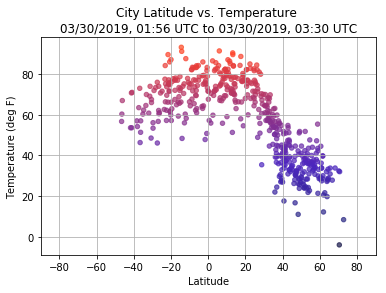

In [20]:
weather_df.plot(kind='scatter',x='Latitude',y='Temperature (deg F)',
                title='City Latitude vs. Temperature \n' +
                '%s UTC ' % weather_df['Time'].min().strftime('%m/%d/%Y, %H:%M') +
                'to %s UTC' % weather_df['Time'].max().strftime('%m/%d/%Y, %H:%M'),
                grid=True,xlim=(-90,90),c='Temperature (deg F)', colormap = 'CMRmap',
                vmax = 200, vmin = -20, colorbar = False, alpha = 0.7)

plt.savefig('output_data/lat_v_temp.png')

#### Latitude vs. Humidity Plot

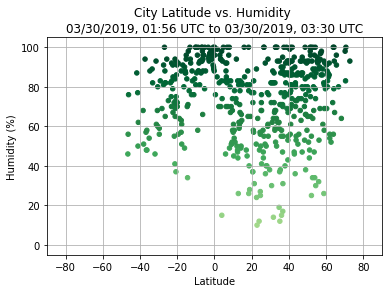

In [21]:
weather_df.plot(kind='scatter',x='Latitude',y='Humidity (%)',
                title='City Latitude vs. Humidity \n' +
                '%s UTC ' % weather_df['Time'].min().strftime('%m/%d/%Y, %H:%M') +
                'to %s UTC' % weather_df['Time'].max().strftime('%m/%d/%Y, %H:%M'),
                ylim = (-5, 105),
                grid=True,xlim=(-90,90),c='Humidity (%)', colormap = 'YlGn',
                vmax = 100, vmin = -50, colorbar = False)
plt.savefig('output_data/lat_v_humid.png')

#### Latitude vs. Cloudiness Plot

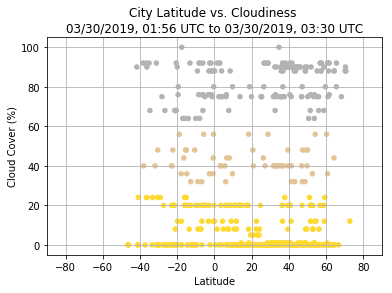

In [22]:
weather_df.plot(kind='scatter',x='Latitude',y='Cloud Cover (%)',
                title='City Latitude vs. Cloudiness \n' +
                '%s UTC ' % weather_df['Time'].min().strftime('%m/%d/%Y, %H:%M') +
                'to %s UTC' % weather_df['Time'].max().strftime('%m/%d/%Y, %H:%M'),
                ylim = (-5, 105),
                grid=True,xlim=(-90,90),c='Cloud Cover (%)', colormap = 'Set2',
                vmax = 100, vmin = -200, colorbar = False)
plt.savefig('output_data/lat_v_cloud.png')

#### Latitude vs. Wind Speed Plot

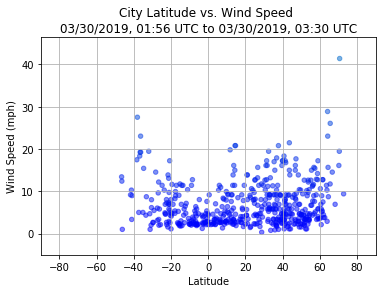

In [23]:
weather_df.plot(kind='scatter',x='Latitude',y='Wind Speed (mph)',
                title='City Latitude vs. Wind Speed \n' +
                '%s UTC ' % weather_df['Time'].min().strftime('%m/%d/%Y, %H:%M') +
                'to %s UTC' % weather_df['Time'].max().strftime('%m/%d/%Y, %H:%M'),
                ylim = (-5, weather_df['Wind Speed (mph)'].max() + 5),
                grid=True,xlim=(-90,90),c='Wind Speed (mph)', colormap = 'winter',
                vmax = 100, vmin = 0, colorbar = False, alpha = 0.5)
plt.savefig('output_data/lat_v_wind.png')

### Statistical Analysis

* The latitude value will be used to check for northern vs. southern hemisphere effects
* A new column "Distance from Equator (km)" will be appended to DataFrame and used for analysis
* The key output variables will be Spearman (rank value) correlations because normality and linearity are not proven
* We will use t-test probabilities for the correlation coefficients, but we will treat 95-99% significance as marginal, in order to account for potential errors when using Spearman coefficients 

In [16]:
# First, add the new DataFrame column
weather_df['Distance from Equator (km)'] = abs(111.13 * weather_df['Latitude'])
# Then generate the matrix of correlation coefficients as a new DataFrame
rs_df = weather_df.corr(method='spearman')
rs_df

,Latitude,Longitude,Temperature (deg F),Humidity (%),Wind Speed (mph),Cloud Cover (%),Distance from Equator (km)
Latitude,1.000000,-0.021224,-0.739962,-0.001161,0.132318,0.063554,0.787321
Longitude,-0.021224,1.000000,0.031089,-0.086134,-0.026797,-0.036369,0.020597
Temperature (deg F),-0.739962,0.031089,1.000000,-0.095763,-0.050284,-0.108890,-0.829201
Humidity (%),-0.001161,-0.086134,-0.095763,1.000000,-0.131860,0.369481,-0.065260
Wind Speed (mph),0.132318,-0.026797,-0.050284,-0.131860,1.000000,0.071201,0.248003
Cloud Cover (%),0.063554,-0.036369,-0.108890,0.369481,0.071201,1.000000,0.048283
Distance from Equator (km),0.787321,0.020597,-0.829201,-0.065260,0.248003,0.048283,1.000000


Howell (2013) - Statistical Methods for Psychology (8th ed.). provides an approximate test for significant when using Spearman's correlation coefficients, basically the same formula as for Pearson values, but with the caution that the result is qualitative.  The accepted practice is simply to note borderline cases, so in this case we will label 95-99% confidence as " of marginal signficiance" and 99%+ as "likely significant"

In [17]:
#First, generate the significance thresholds for 95% and 99% (two-tailed) 
# These depend only on the degrees of freedom, which is N - 2.  
t95 = t.ppf(0.975,len(weather_df) - 2)
t99 = t.ppf(0.995,len(weather_df) - 2)
# Next, transform the DataFrame to generate t-values using the correlation coefficient formula,
# which is t = r * sqrt(N - 2) / sqrt(1-r^2)
t_df = rs_df.transform(lambda x: x * np.sqrt((len(weather_df) - 2)) / np.sqrt(1 - np.power(x,2)))
t_df

,Latitude,Longitude,Temperature (deg F),Humidity (%),Wind Speed (mph),Cloud Cover (%),Distance from Equator (km)
Latitude,inf,-0.477066,-24.721010,-0.026080,2.999860,1.431091,28.696793
Longitude,-0.477066,inf,0.698972,-1.942850,-0.602413,-0.817835,0.462955
Temperature (deg F),-24.721010,0.698972,inf,-2.161948,-1.131431,-2.461637,-33.337446
Humidity (%),-0.026080,-1.942850,-2.161948,inf,-2.989276,8.935339,-1.469667
Wind Speed (mph),2.999860,-0.602413,-1.131431,-2.989276,inf,1.604119,5.752908
Cloud Cover (%),1.431091,-0.817835,-2.461637,8.935339,1.604119,inf,1.086288
Distance from Equator (km),28.696793,0.462955,-33.337446,-1.469667,5.752908,1.086288,inf


In [18]:
# Finally, we will build a significance matrix using DataFrane cuts
# Define bins and labels
sig_bins = [np.NINF,-1 * t99, -1 * t95, t95, t99, np.PINF]
sig_labels = ['likely (-)','marginal (-)', 'no','marginal (+)','likely (+)']
# Buils a new DataFrame using dictionary comprehension
sig_df = pd.DataFrame({col : pd.cut(t_df[col],bins = sig_bins, labels = sig_labels, right = False) for col in t_df})
# Improve readability by blanking out NaN's
sig_df = sig_df.astype('str')
sig_df = sig_df.replace(to_replace='nan',value='')
sig_df

,Latitude,Longitude,Temperature (deg F),Humidity (%),Wind Speed (mph),Cloud Cover (%),Distance from Equator (km)
Latitude,,no,likely (-),no,likely (+),no,likely (+)
Longitude,no,,no,no,no,no,no
Temperature (deg F),likely (-),no,,marginal (-),no,marginal (-),likely (-)
Humidity (%),no,no,marginal (-),,likely (-),likely (+),no
Wind Speed (mph),likely (+),no,no,likely (-),,no,likely (+)
Cloud Cover (%),no,no,marginal (-),likely (+),no,,no
Distance from Equator (km),likely (+),no,likely (-),no,likely (+),no,


### Discussion of Statistical Results

* The strongest correlation is the negative relationship between temperature and the distance from the equator.  There is also a strong hemispheric effect, with the Southern Hemisphere being in general warmer having a weaker dependence of temperature on latitude.  Although these data were collected in the Northern Hemisphere early spring, global temperatures tend to lag solar input by about six weeks, so the Southern Hemisphere should be warmer in late March.  Some of the observed variation in current temperature is diurnal.
* Wind speeds also show a likely significant dependent on both distance from the equator and latitude.  The correlation with distance from the equator is much stronger, with winds being on average stronger near the poles. The correlation coefficients are weak, however.  In this case, likely statistical significance is driven by the large size of the data set.  The plot of wind speed vs. latitude shows that stronger winds tend to be present near the poles but not the tropics.  Such effects may reflect the seasonal distribution of storm systems.
* As may be expected, there is a likely significant positive correlation between cloud cover and humidity. There is also a likely significant negative correlation (with a very low coefficient, indicating a weak effect) between wind speed and humidity.  
* There were marginally signfiicant correlations between cloud cover and temperature (negative, as might be expected), and between cloud cover and humidity (negative, which is contrary to expectations).  These correlations would be significant at 95% confidence under assumptions of normally distributed data and linear effects.  
* A trivially significant correlation was also observed between latitude and distance from the equator.  This correlation arises because the locations sampled (cities) fall into a band principally from about 45 degrees S to 65 degrees N, with substantially more cities in the Northern Hemisphere.  
* It is worth noting that beyond the trivial relationships examined, 20 possible correlations were examined, with 8 found to be marginally or likely significant.  Given the limited quantiative statistical analysis that can be done in the absence of more detailed examination of the data, the risk of one or more spurious correlations is substantial.  A worthwhile future activity would be to check these correlations for robustness to different data sets and analysis methods.  